This notebook shows how to build a model to classify text, using the TREC-6 dataset.

The TREC-6 dataset consist on a set of 5,952 questions written in English, classified in the following categories, depending on the answer:

* HUM: Human
* DESC: Description
* ABBR: Abbreviation
* LOC: Location
* NUM: Number
* ENTY: Entity

# Install and import required libraries

In [1]:
# The following lines will install the torchtext and spacy libraries, 
# used to prepare text datasets for models in PyTorch.

!pip install torchtext spacy
#!conda install -c conda-forge spacy -y
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/Users/cenk.bircanoglu/.pyenv/versions/learn-pytorch/lib/python3.6/site-packages/en_core_web_sm
-->
/Users/cenk.bircanoglu/.pyenv/versions/learn-pytorch/lib/python3.6/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [2]:
from torchtext import data, datasets
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

# 1 - Data preparation

In [3]:
# Get datasets
text_field = data.Field(lower=True, batch_first=True, tokenize='spacy')
label_field = data.Field(sequential=False, unk_token = None)
train, test = datasets.TREC.splits(text_field, label_field)

print('Train length:',str(len(train)))
print('Test length:',str(len(test)))

Train length: 5452
Test length: 500


In [4]:
# Show some examples

for i in range(10):
    random_index = random.randint(0,len(train))
    print(' '.join(train.examples[random_index].text), train.examples[random_index].label)

how long does it take the typical american to eat 23 quarts of ice cream ? NUM
saddam hussein was compared to whom by president bush ? HUM
what is the homelite inc. home page ? LOC
what was the first funk ' n lata , brazilian group , success ? DESC
who is section manager for guidance and control systems at jpl ? HUM
what does s.o.s. stand for ? ABBR
what is splatterpunk ? DESC
how many points are there on a backgammon board ? NUM
how do cameras take pictures ? DESC
who is samuel pickering ? HUM


In [5]:
# Build vocabulary
vocab_length = 5000
text_field.build_vocab(train, max_size=vocab_length)
label_field.build_vocab(train)

classes_count = len(label_field.vocab)
word_count = len(text_field.vocab)
print('Vocabulary length:', word_count)
print('Number of classes:', classes_count)


Vocabulary length: 5002
Number of classes: 6


In [6]:
# Vocab dictionaries
text_field.vocab.stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x12ac260f0>>,
            {'<unk>': 0,
             '<pad>': 1,
             '?': 2,
             'the': 3,
             'what': 4,
             'is': 5,
             'of': 6,
             'in': 7,
             'a': 8,
             '`': 9,
             'how': 10,
             "'s": 11,
             'was': 12,
             'to': 13,
             'who': 14,
             ',': 15,
             'are': 16,
             'for': 17,
             'and': 18,
             "''": 19,
             'does': 20,
             'did': 21,
             '-': 22,
             'do': 23,
             'many': 24,
             'name': 25,
             'on': 26,
             'where': 27,
             'i': 28,
             'first': 29,
             'you': 30,
             'can': 31,
             'when': 32,
             'world': 33,
             'from': 34,
             'which': 35,
             'by': 36,
             'that': 37

# 2 - Build model

In [7]:
class RNN(nn.Module):
    def __init__(self, num_tokens, embedding_dim, rnn_dim, num_layers, num_classes):
        super(RNN, self).__init__()
        self.embeddings = nn.Embedding(num_tokens, embedding_dim)
        self.rnn = nn.LSTM(input_size = embedding_dim,
                           hidden_size = rnn_dim, 
                           num_layers = num_layers,
                           batch_first = True,
                           bidirectional=False)
        self.linear = nn.Linear(rnn_dim, num_classes)
        
    def forward(self, x):
        emb = self.embeddings(x)
        rnn_output, rnn_hidden = self.rnn(emb) 
        x = rnn_output[:,-1,:]
        x = self.linear(x)
        return x
    
model = RNN(word_count, 6, 6, 1, classes_count)
model

RNN(
  (embeddings): Embedding(5002, 6)
  (rnn): LSTM(6, 6, batch_first=True)
  (linear): Linear(in_features=6, out_features=6, bias=True)
)

# 3 - Objective function (and optimizer)

In [8]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lr_decay = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

# 4 - Train model (and test during training)

In [9]:
batch_size = 32
num_epochs = 20

train_iter = data.BucketIterator(train, 
                                 batch_size=batch_size, 
                                 sort_within_batch=True, 
                                 shuffle = True, 
                                 repeat = False)

test_iter = data.BucketIterator(test, 
                          batch_size=30, 
                          sort_within_batch=True, 
                          shuffle = True, 
                          repeat = False)

In [10]:
# Reset variables 
accuracies = []
losses_train = []
losses_test = []
train_accuracy = 0
step_count = 0
max_accuracy = 0

In [11]:
# Training loop
model.train()
for i in range(num_epochs):
    print('Training epoch ',i)
    train_iter.init_epoch()
    for batch in train_iter:        

        x_train = batch.text
        y_train = batch.label

        # Forward pass
        y_model = model(x_train)

        # Loss function
        loss = loss_function(y_model, y_train)
        losses_train.append(float(loss))

        # Backward pass 
        model.zero_grad()
        loss.backward()
        
        # Update parameters
        optimizer.step()

        # Evaluation in test set

        if step_count%100 == 0:

            # Calculate model in test set by pieces
            model.eval() # Set model to eval (if there is dropout, will set it to zero)
            y_model_test_list = []
            y_test_list = []
            
            for test_batch in test_iter:            
                y_model_test_list.append(model(test_batch.text))            
                y_test_list.append(test_batch.label)
            model.train() # Set model to train (if there is dropout, will not be zero anymore)
            test_iter.init_epoch()
            
            # Calculate accuracy
            accuracy = float( (torch.cat(y_model_test_list).max(dim=1)[1] == torch.cat(y_test_list)).float().mean() )
            print('Step: ', step_count, 'Accuracy in test set:', accuracy)
            accuracies.append(accuracy)

        lr_decay.step()
        step_count += 1

Training epoch  0
Step:  0 Accuracy in test set: 0.16200000047683716
Step:  100 Accuracy in test set: 0.2759999930858612
Training epoch  1
Step:  200 Accuracy in test set: 0.30799999833106995
Step:  300 Accuracy in test set: 0.30799999833106995
Training epoch  2
Step:  400 Accuracy in test set: 0.29600000381469727
Step:  500 Accuracy in test set: 0.335999995470047
Training epoch  3
Step:  600 Accuracy in test set: 0.3540000021457672
Training epoch  4
Step:  700 Accuracy in test set: 0.35600000619888306
Step:  800 Accuracy in test set: 0.3479999899864197
Training epoch  5
Step:  900 Accuracy in test set: 0.36000001430511475
Step:  1000 Accuracy in test set: 0.36800000071525574
Training epoch  6
Step:  1100 Accuracy in test set: 0.40400001406669617
Training epoch  7
Step:  1200 Accuracy in test set: 0.42800000309944153
Step:  1300 Accuracy in test set: 0.4560000002384186
Training epoch  8
Step:  1400 Accuracy in test set: 0.4860000014305115
Step:  1500 Accuracy in test set: 0.48800000548

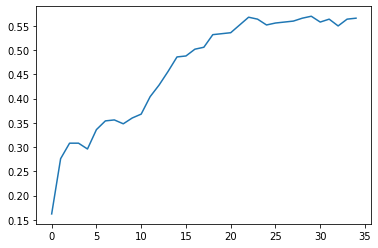

In [12]:
plt.plot(accuracies)

# Exercice: Improve your RNN 

Improve your recurrent network:
* Apply dropout between the LSTM and the linear layer
* Add more complexity to the model (RNN layers, other layers)
* Bidirectional RNN

In [13]:
class RNN(nn.Module):
    def __init__(self, num_tokens, embedding_dim, rnn_dim, num_layers, num_classes):
        super(RNN, self).__init__()
        self.embeddings = nn.Embedding(num_tokens, embedding_dim)
        self.rnn = nn.LSTM(input_size = embedding_dim,
                           hidden_size = rnn_dim, 
                           num_layers = num_layers,
                           batch_first = True,
                           bidirectional=True)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(2*rnn_dim, rnn_dim)
        self.relu = nn.ReLU(True)
        self.dropout2 = nn.Dropout(0.2)
        self.linear2 = nn.Linear(rnn_dim, num_classes)
        
    def forward(self, x):
        emb = self.embeddings(x)
        rnn_output, rnn_hidden = self.rnn(emb) 
        x = self.dropout(rnn_output)
        x = self.linear(rnn_output[:,-1,:])
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.linear2(x)
        return x

model = RNN(word_count, 50, 20, 3, classes_count)
model

RNN(
  (embeddings): Embedding(5002, 50)
  (rnn): LSTM(50, 20, num_layers=3, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=40, out_features=20, bias=True)
  (relu): ReLU(inplace=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (linear2): Linear(in_features=20, out_features=6, bias=True)
)

In [14]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lr_decay = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

In [15]:
batch_size = 32
num_epochs = 20

train_iter = data.BucketIterator(train, 
                                 batch_size=batch_size, 
                                 sort_within_batch=True, 
                                 shuffle = True, 
                                 repeat = False)

test_iter = data.BucketIterator(test, 
                          batch_size=30, 
                          sort_within_batch=True, 
                          shuffle = True, 
                          repeat = False)

In [16]:
# Reset variables 
accuracies = []
losses_train = []
losses_test = []
train_accuracy = 0
step_count = 0
max_accuracy = 0

In [17]:
# Training loop
for i in range(num_epochs):
    print('Training epoch ',i)
    train_iter.init_epoch()
    for batch in train_iter:        

        x_train = batch.text
        y_train = batch.label

        # Forward pass
        y_model = model(x_train)

        # Loss function
        loss = loss_function(y_model, y_train)
        losses_train.append(float(loss))

        # Backward pass 
        model.zero_grad()
        loss.backward()
        
        # Update parameters
        optimizer.step()

        # Evaluation in test set

        if step_count%100 == 0:

            # Calculate model in test set by pieces
            model.eval() # Set model to eval (if there is dropout, will set it to zero)
            y_model_test_list = []
            y_test_list = []
            
            for test_batch in test_iter:            
                y_model_test_list.append(model(test_batch.text))            
                y_test_list.append(test_batch.label)
            model.train() # Set model to train (if there is dropout, will not be zero anymore)
            test_iter.init_epoch()
            
            # Calculate accuracy
            accuracy = float( (torch.cat(y_model_test_list).max(dim=1)[1] == torch.cat(y_test_list)).float().mean() )
            print('Step: ', step_count, 'Accuracy in test set:', accuracy)
            accuracies.append(accuracy)

        lr_decay.step()
        step_count += 1

Training epoch  0
Step:  0 Accuracy in test set: 0.2759999930858612
Step:  100 Accuracy in test set: 0.12999999523162842
Training epoch  1
Step:  200 Accuracy in test set: 0.3700000047683716
Step:  300 Accuracy in test set: 0.5659999847412109
Training epoch  2
Step:  400 Accuracy in test set: 0.5799999833106995
Step:  500 Accuracy in test set: 0.5899999737739563
Training epoch  3
Step:  600 Accuracy in test set: 0.6240000128746033
Training epoch  4
Step:  700 Accuracy in test set: 0.628000020980835
Step:  800 Accuracy in test set: 0.656000018119812
Training epoch  5
Step:  900 Accuracy in test set: 0.6779999732971191
Step:  1000 Accuracy in test set: 0.7179999947547913
Training epoch  6
Step:  1100 Accuracy in test set: 0.7160000205039978
Training epoch  7
Step:  1200 Accuracy in test set: 0.7319999933242798
Step:  1300 Accuracy in test set: 0.734000027179718
Training epoch  8
Step:  1400 Accuracy in test set: 0.7039999961853027
Step:  1500 Accuracy in test set: 0.765999972820282
Train